In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp

/tmp/ipykernel_1557982/552139305.py:19: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
#import required R packages
soupx = ro.packages.importr('SoupX') 
scran = ro.packages.importr('scran') 
bcp = ro.packages.importr('BiocParallel') 
scry = ro.packages.importr('scry')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

### 1. Import all the data

In [5]:
path_to_folders = './01_data/raw/cellranger_multi'
path_to_count_matrices_in_folders = 'per_sample_outs/count/sample_filtered_feature_bc_matrix'
path_to_raw_count_matrices_in_folders = 'count/raw_feature_bc_matrix'

adatas = dp.read_all_pools(path_to_folders, path_to_count_matrices_in_folders)
adatas_raw = dp.read_all_pools(path_to_folders, path_to_raw_count_matrices_in_folders)

Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P2_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P3_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P4_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P5_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P6_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P7_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellra

### 2. Transfer HTOs from count to obs column to avoid influence on SoupX and quality control

In [6]:
adatas, adatas_raw, conditions = dp.transfer_htos(adatas, adatas_raw)

### 3. perform quality control

In [7]:
# adatas_mad = dp.quality_control(adatas)
# adatas_qc = dp.quality_control(adatas)
# adatas_qc = dp.quality_control(adatas, method = 'qntl')
adatas_qc = dp.quality_control(adatas, method = 'abs')

computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9


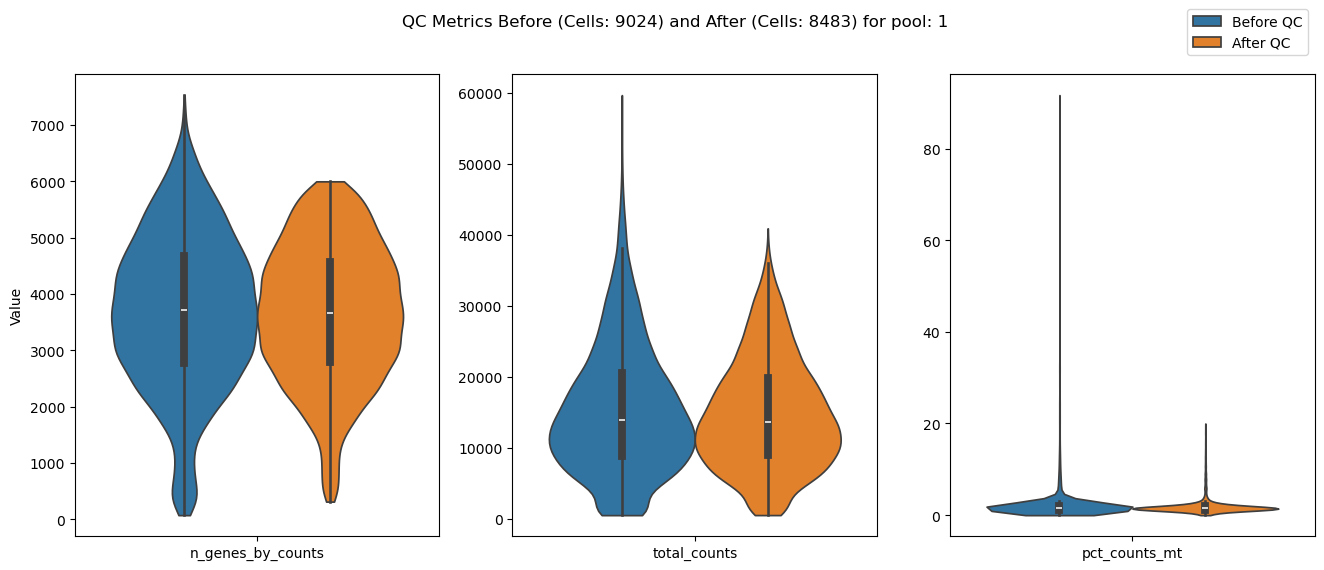

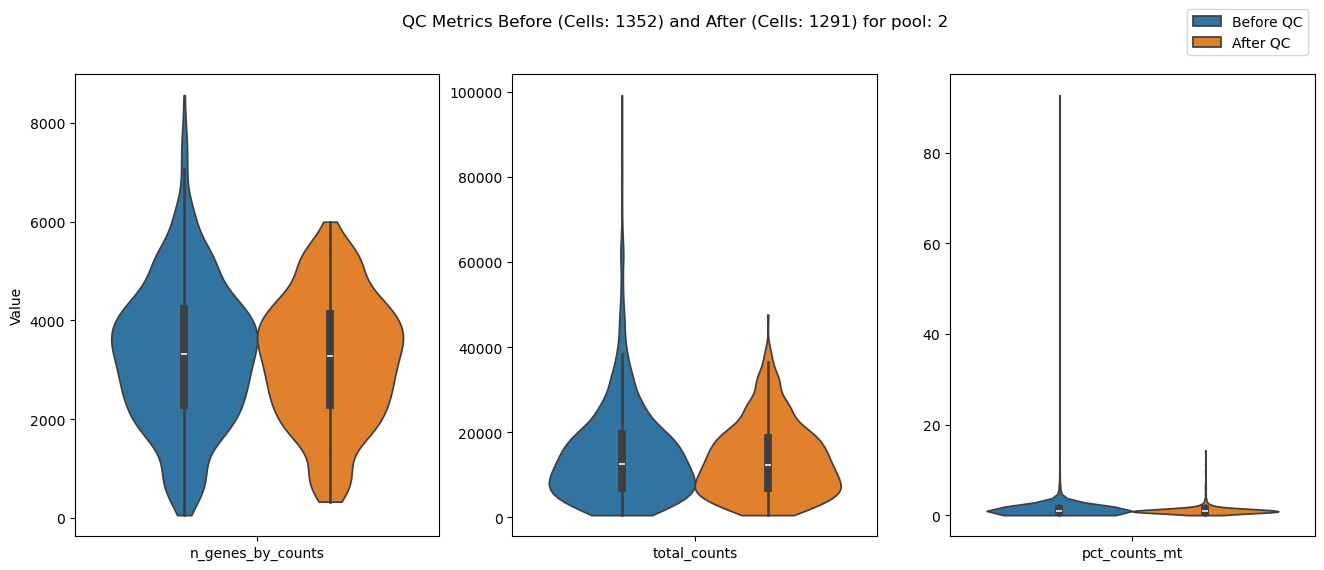

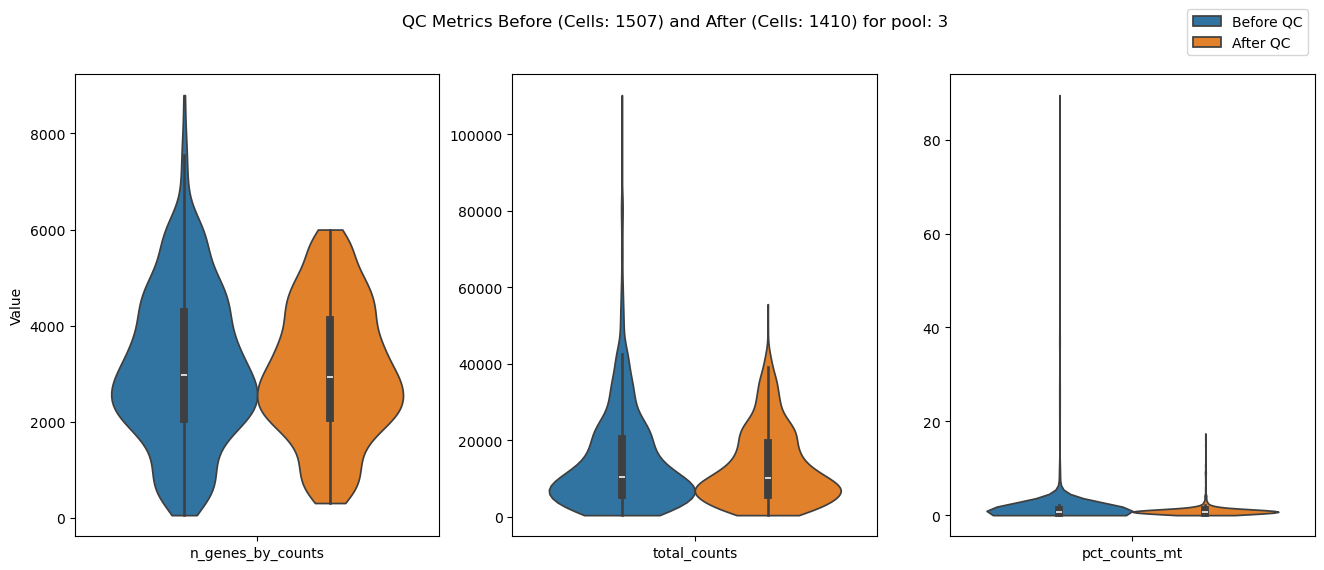

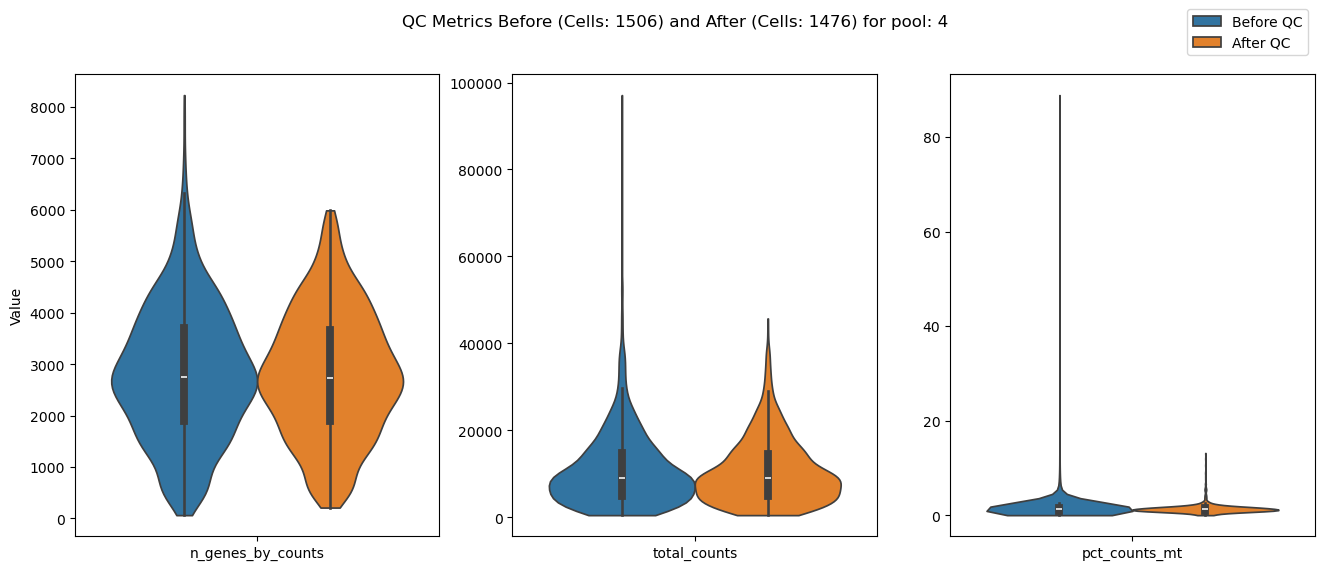

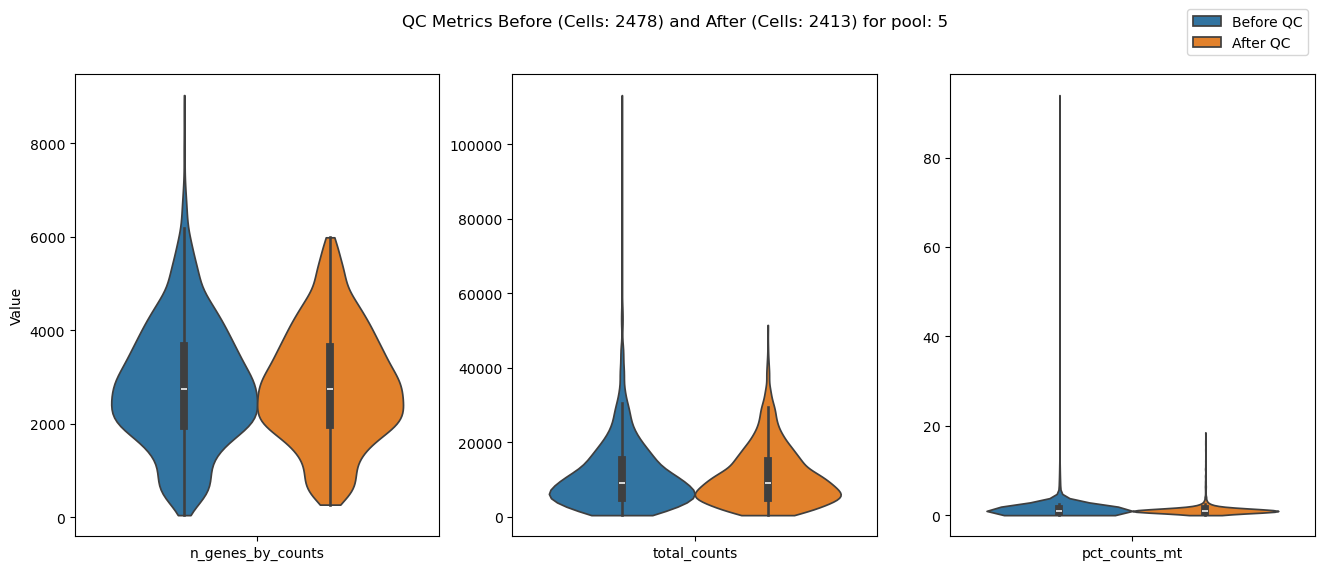

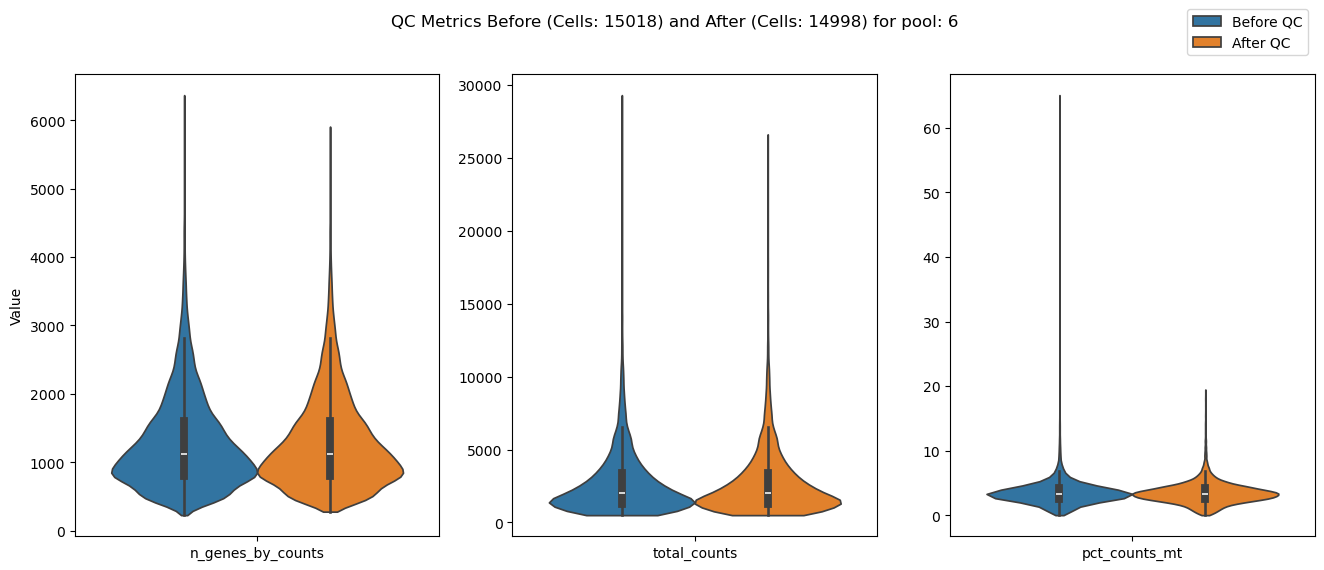

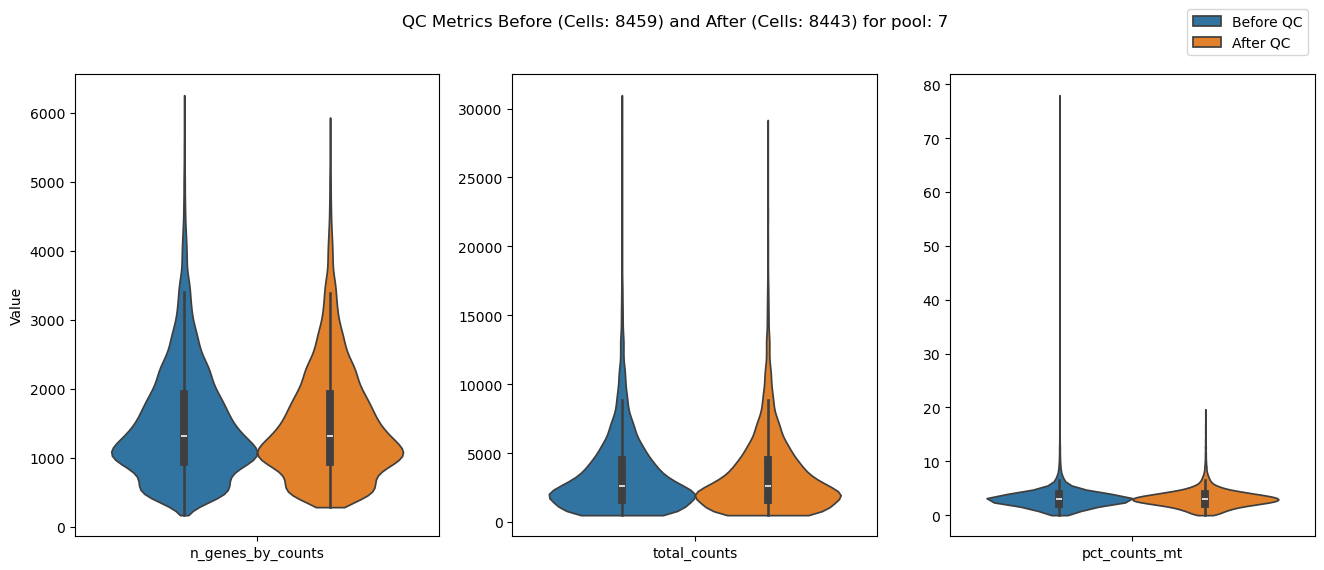

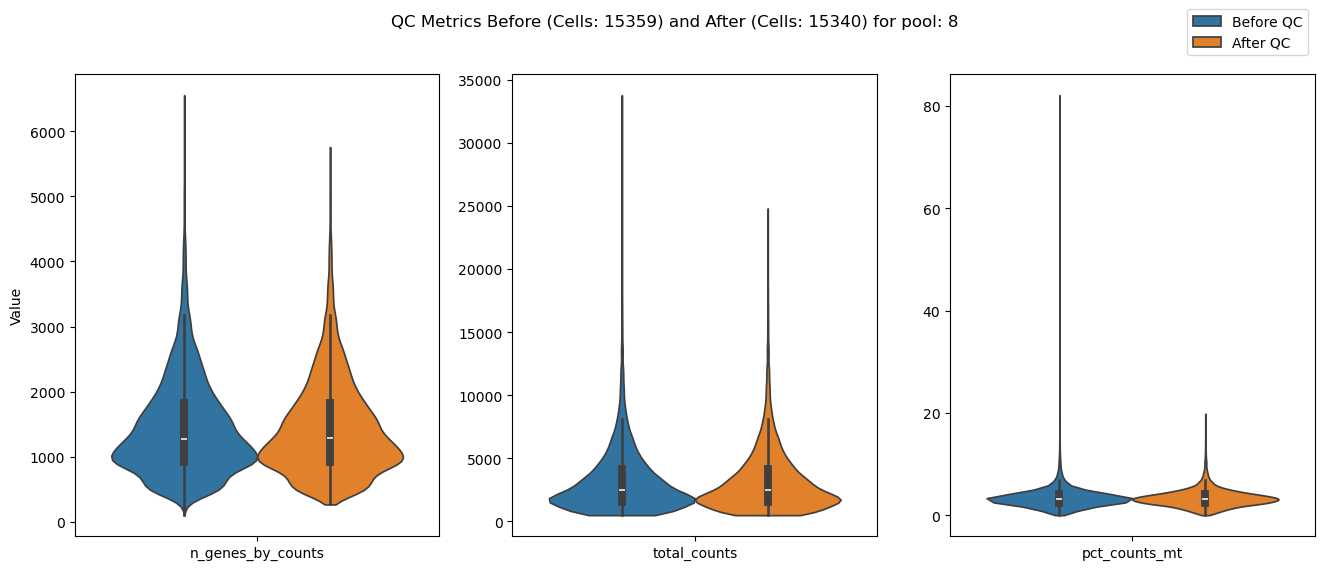

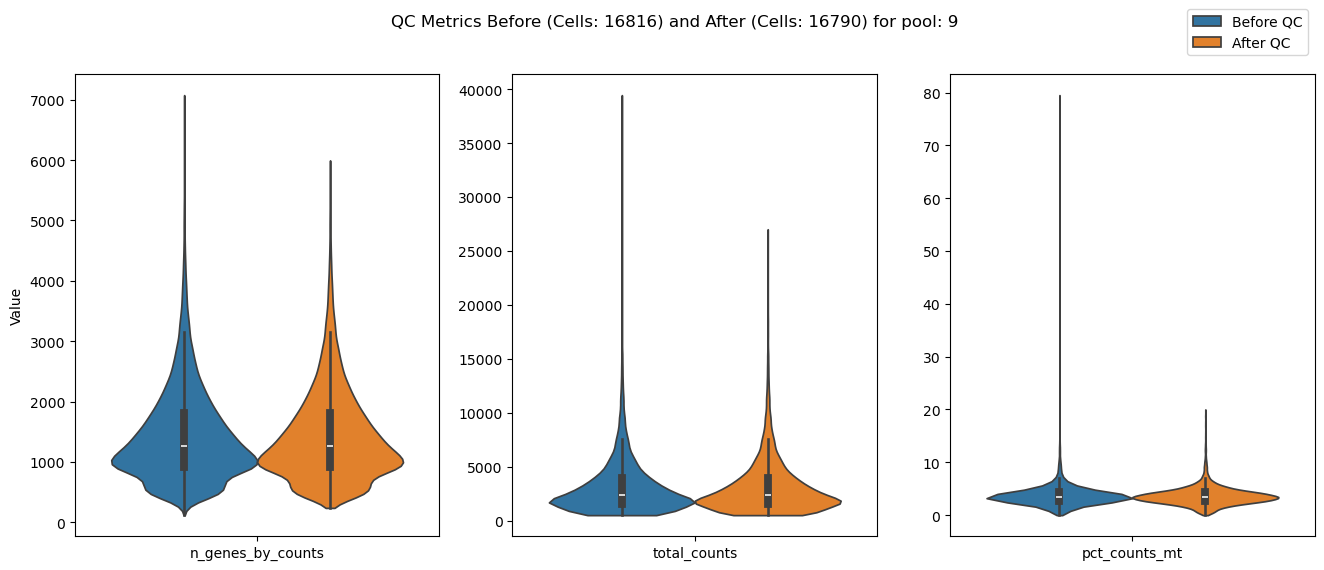

In [27]:
dp.plot_qc_metrics(adatas, adatas_qc)

In [8]:
adatas = adatas_qc

### 4. Perform SoupX to correct for ambient mRNA

In [9]:
groups = [dp.pregroup(adata) for adata in adatas]
adatas = [dp.cook_soup(adata, adata_raw, group) for (adata, adata_raw, group) in zip(adatas, adatas_raw, groups)]

### 5. Demultiplex the data using hashsolo (needs to be after qc since its based on priot probabilities that assume cells have passed filtering. Also, reasonable after SoupX, since filtering out doublets etc. will affect the soupx clusters)

In [15]:
dp.demultiplex(adatas, conditions)
adatas = [dp.filter_for_singlets(adata) for adata in adatas]

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


### 6. Normalize the data using shifter logarithm or scran normalization

In [17]:
dp.log1p_norm(adatas)
groups = [dp.pregroup(adata, resolution=15) for adata in adatas]
adatas= [dp.scran_norm(adata, group) for (adata, group) in zip(adatas, groups)]

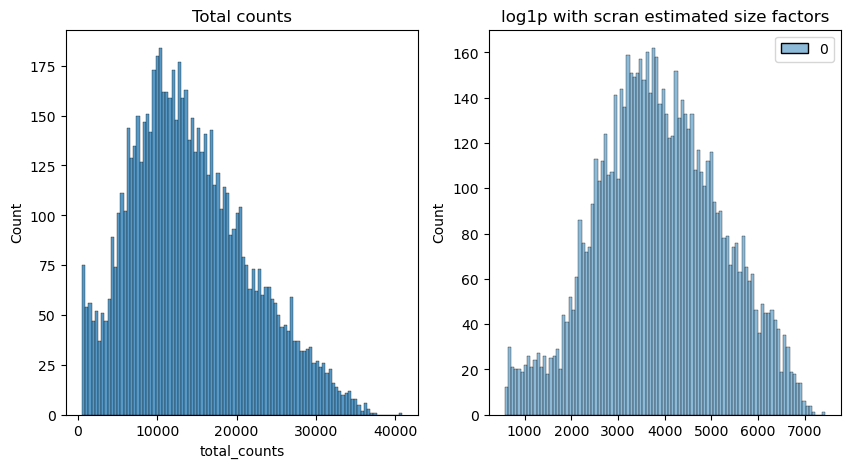

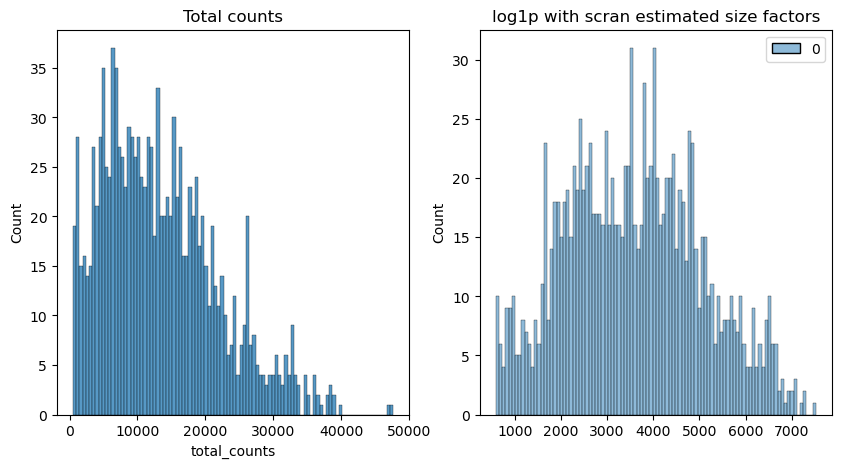

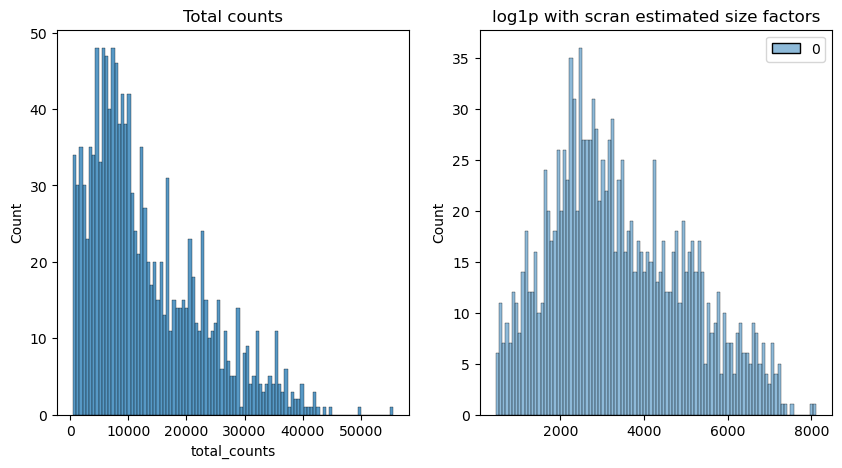

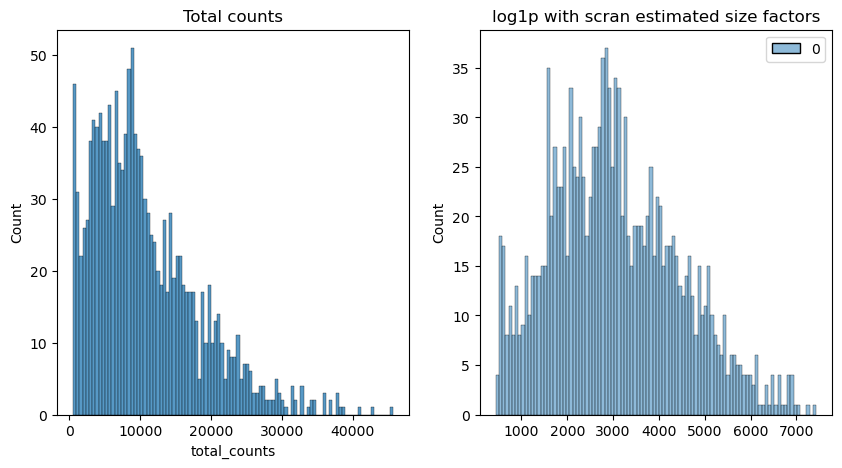

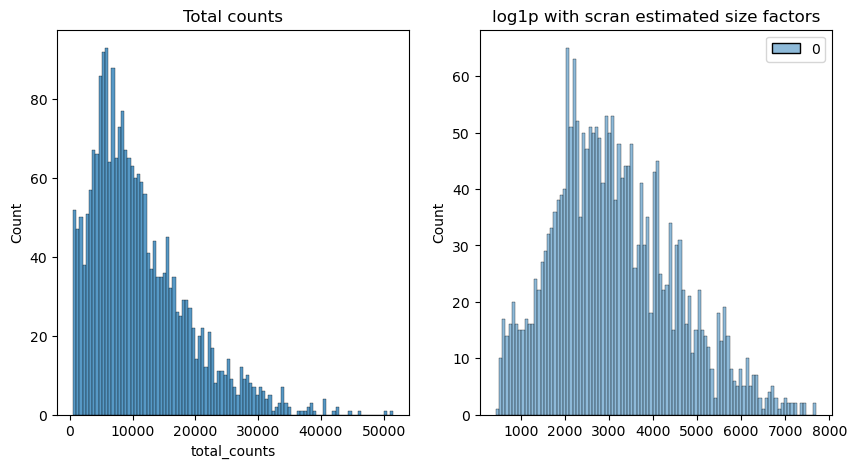

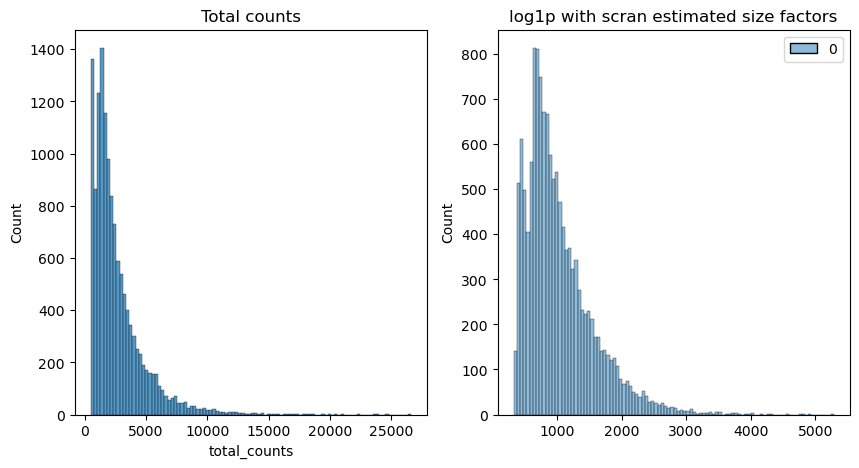

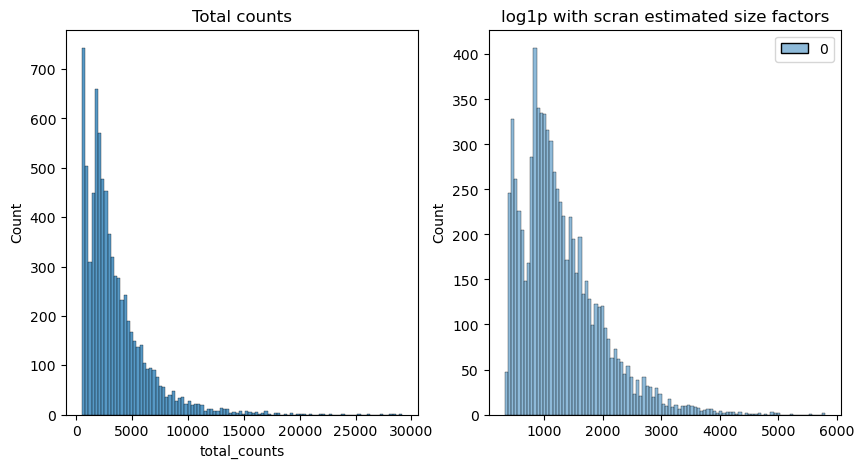

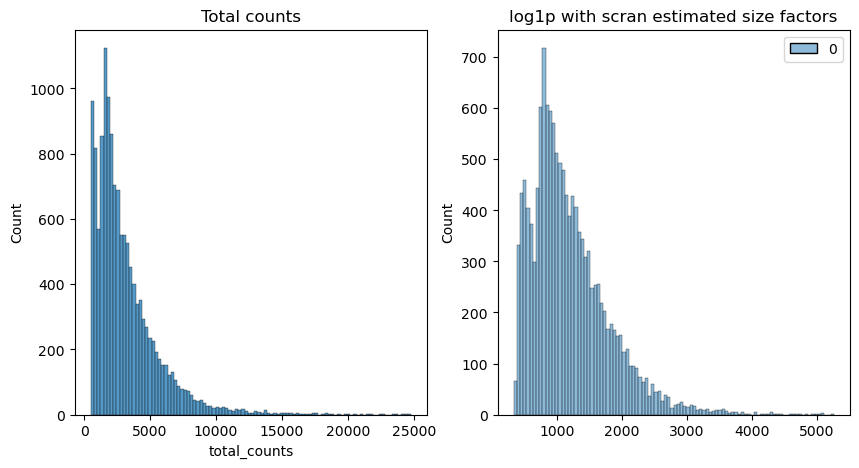

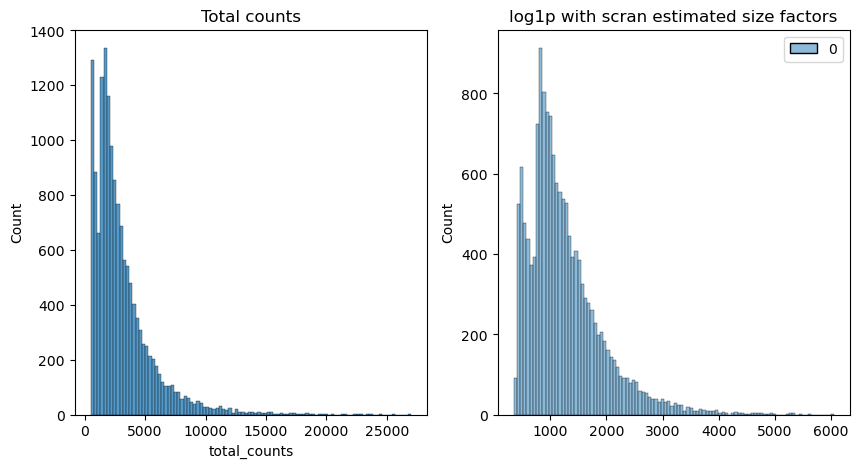

In [19]:
dp.plot_normalization(adatas, 'scran_normalization', 'scran')

### 7. Concatenate/merge all the pools and perform feature selection

In [27]:
adata_merged = ad.concat(adatas, join='inner', label='dataset',index_unique='_')
sc.pp.highly_variable_genes(adata_merged, layer='log1p', n_top_genes=2000, flavor="cell_ranger", batch_key='dataset')

In [28]:
adata_merged[:, adata_merged.var.highly_variable]

View of AnnData object with n_obs × n_vars = 63674 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'size_factors', 'dataset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'soupX_counts', 'log1p', 'scran_normalization'

In [33]:
#plot the unintegrated data with coloring the discrete datasets to see their difference
sc.tl.pca(adata_merged, mask_var=None)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)
adata_merged

AnnData object with n_obs × n_vars = 63674 × 33696
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'size_factors', 'dataset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'dataset_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'soupX_counts', 'log1p', 'scran_normalization'
    obsp: 'distances', 'connectivities'

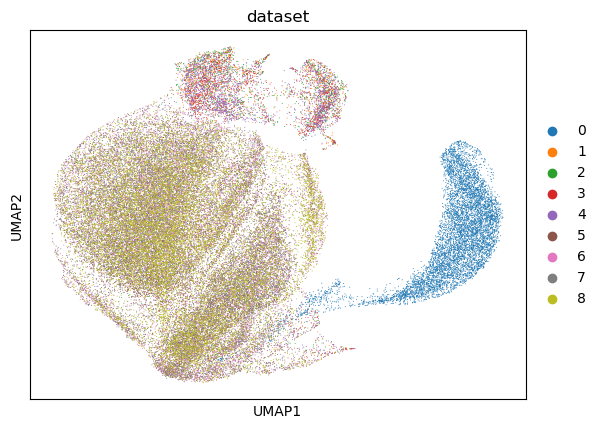

In [34]:
sc.pl.umap(adata_merged, color='dataset', wspace=1)

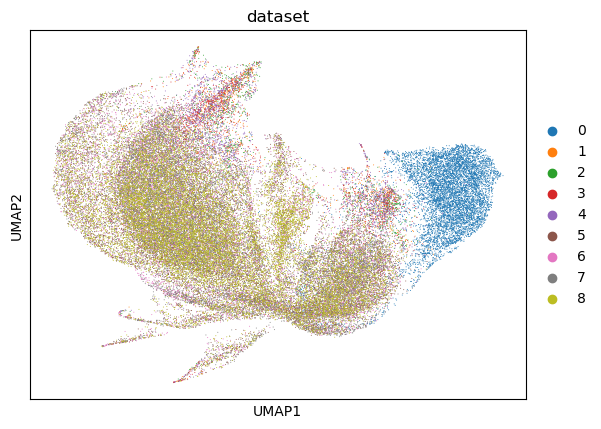

In [30]:
sc.pl.umap(adata_merged, color='dataset', wspace=1)

### 8. Perform data integration

### 9. Safe the data

In [200]:
adata_merged.write('01_data/processed/qc/merged_qc_abs.h5ad', compression='gzip')

<module 'functions_dat_processing' from '/home/s377963/car_t_sc/02_code/functions/functions_dat_processing.py'>